# Add +/- 1 standard deviation to the map_soln prediction plot

In [2]:
import round.lc as lc
import matplotlib.pyplot as plt
%matplotlib inline

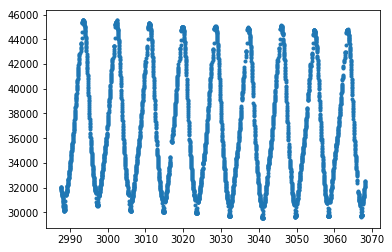

In [17]:
light_curve = lc.LightCurve.everest("https://archive.stsci.edu/hlsps/everest/v2/c13/247700000/61523/hlsp_everest_k2_llc_247761523-c13_kepler_v2.0_lc.fits")
plt.plot(light_curve.t, light_curve.raw_flux, '.')

In [21]:
light_curve.normalize()

In [22]:
light_curve.yerr

array([0., 0., 0., ..., 0., 0., 0.])

In [4]:
%time light_curve.compute(mcmc=True, mcmc_draws=500, tune=500, target_accept=0.9, prior_sig=3.0, with_SHOTerm=False, cores=2, maxper=20)

AttributeError: <pymc3.distributions.continuous.Normal object at 0x122ccff98> has no finite default value to use, checked: ('median', 'mean', 'mode'). Pass testval argument or adjust so value is finite.

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 10))
really_outer = gridspec.GridSpec(1, 1, wspace=0.2, hspace=0.2)
outer = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=really_outer[0], wspace=0.2, hspace=0.2)
inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.3)

# raw light curve and polynomial fit 
ax = plt.Subplot(fig, inner[0])
light_curve.plot_raw(ax, 'k.', label="everest flux")
light_curve.plot_trend(ax, linewidth=3, color="#f55649", label="third order polynomial fit")
ax.plot(light_curve.raw_t[light_curve.masked], light_curve.raw_flux[light_curve.masked], 'r.', label="masked outliers")
ax.set_title("Raw Everest Light Curve", fontsize=20)
ax.set_xlabel("Time (BJD - 2454833)", fontsize=15)
ax.set_ylabel("Flux", fontsize=15)
ax.legend()
fig.add_subplot(ax)

# autocorrelation
mcmc_period = np.exp(light_curve.mcmc_summary["mean"]["logperiod"])
ax = plt.Subplot(fig, inner[1])
light_curve.plot_autocor(ax, "k", linewidth=3, maxper=20)
ax.axvline(light_curve.map_soln["period"], color="#f55649", label="maximum likelihood period", linewidth=3, linestyle="--")
ax.axvline(mcmc_period, color="#53bff5", label="mean period from MCMC", linewidth=3, linestyle="--")
ax.set_title("Autocorrelation", fontsize=20)
ax.set_xlabel("Lag (BJD)", fontsize=15)
ax.set_ylabel("ACF", fontsize=15)
ax.legend()
fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], wspace=0.1, hspace=0, height_ratios=[3, 1])

# GP prediction
ax = plt.Subplot(fig, inner[0])
light_curve.plot(ax, 'k.', label="normalized everest flux")
light_curve.plot_map_soln(ax, t=np.linspace(light_curve.t[0], light_curve.t[-1], 1000), linewidth=3, color="#f55649", label="GP prediction")
ax.set_title("Maximum-likelihood GP Prediction", fontsize=20)
ax.set_ylabel("Normalized Flux", fontsize=15)
fig.add_subplot(ax)

# residuals
ax = plt.Subplot(fig, inner[1])
#ax.plot(light_curve.t, light_curve.flux - light_curve.map_soln["mu"], 'k.')
light_curve.plot_residuals(ax, 'k.')
ax.set_ylabel("Residuals", fontsize=15)
ax.set_xlabel("Time (BJD - 2454833)", fontsize=15)
fig.add_subplot(ax)

fig.savefig("/Users/tgordon/Desktop/diagnostic_plot.png", dpi=200)

In [ ]:
light_curve.write_summary_string("test.dat", 0)

In [ ]:
light_curve.plot_corner(smooth=True, truths=light_curve.mcmc_summary["mean"].values, truth_color="#f55649");
plt.savefig("/Users/tgordon/Desktop/corner_plot.pdf")

In [ ]:
import numpy as np

In [ ]:
ckpt = np.genfromtxt('../ckpts/.ckpt_3', dtype=str)
ckpt[0:10, 1] = ['1']*10
np.savetxt('../ckpts/.ckpt_3', ckpt, fmt="%s")

In [ ]:
fileids = np.array(range(len(ckpt)))[ckpt[:, 1] == '0']

In [ ]:
ckpt = np.genfromtxt('../ckpts/.ckpt_3', dtype=str)
files = ckpt[:, 0][ckpt[:, 1] == '0']
fileids = np.array(range(len(ckpt)))[ckpt[:, 1] == '0']

In [ ]:
for i, file in zip(fileids[0:10], files[0:10]):
    print(i, file)
    ckpt[i, 1] = '1'
    np.savetxt('../ckpts/.ckpt_3', ckpt, fmt="%s")

In [ ]:
lags, power, _ = light_curve.autocor(max_peaks=1, min_period=0.5)
peaks, troughs, heights = light_curve.get_peaks(lags, power)
light_curve.acfpeaks = peaks
maxper = light_curve.t[-1]-light_curve.t[0]
searchpeaks = peaks[peaks < maxper]
heights = np.array(heights)
searchheights = heights[peaks < maxper]

In [ ]:
peaks < maxper

In [ ]:
heights

In [ ]:
troughs

In [ ]:
peaks

In [ ]:
peaks[:-1]

In [ ]:
arr = np.array([1, 2, 3, 4, 5])

In [ ]:
np.append(arr, 7)

In [ ]:
arr

In [ ]:
np.insert(arr, 0, 7)

In [ ]:
arr[arr == np.max(arr)]

In [ ]:
arr[4:5]

In [ ]:
string = "test string"

In [ ]:
string[2:4]

In [ ]:
eid = "211946007"
campaign = "05"
url = "https://archive.stsci.edu/hlsps/everest/v2/c" + campaign + "/" + eid[:4] + "00000/" + eid[4:] + "/hlsp_everest_k2_llc_" + eid + "-c" + campaign + "_kepler_v2.0_lc.fits"

In [ ]:
light_curve = lc.LightCurve.everest(url)

In [ ]:
plt.plot(light_curve.t, light_curve.raw_flux)

In [ ]:
light_curve = lc.LightCurve.everest("https://archive.stsci.edu/hlsps/everest/v2/c05/211900000/46007/hlsp_everest_k2_llc_211946007-c05_kepler_v2.0_lc.fits")

In [ ]:
plt.plot(light_curve.t, light_curve.raw_flux)